# Local Alignments with Affine Gap Penalties

Just like we taxed opening gaps more than extended gaps while doing global alignments, we can do the same for local alignments.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import sequence_alignment as seq

In [2]:
seq_2 = "KKASKASPKKPHPHHSPRNGGGGLGKK"
seq_1 = "KKSGGLLLGK"

Specify an opening ($g_{open}$) and an extension gap penalty ($g_{ext}$).

In [3]:
g_open = -6; g_ext = -2

## 1. Initialization
The initialized scoring matrix is identical to the linear gap penalty case: $M_{(i,j)} = 0 \ \forall\ i,j$ 

In [4]:
#initialize the scoring matrix
m = len(seq_1); n = len(seq_2)
M = np.zeros([m+1,n+1])

The helper matrices $U$ and $L$ need to be initialized as follows: <br>
$$U_{(0,0)} = L_{(0,0)} = 0$$ <br>
$$U_{(0,j)} = L_{(0,j)} = 2g_{open}\ \forall \ j>0$$ <br>
$$U_{(i,0)} = L_{(i,0)} = 2g_{open}\ \forall \ i>0$$

where $g_{open}$ is the opening gap penalty.

In [5]:
#initialize the helpers
U = np.copy(M); L = np.copy(M)
U[0,0] = 0; L[0,0] = 0
U[0,1:] = 2*g_open; L[0,1:] = 2*g_open
U[1:,0] = 2*g_open; L[1:,0] = 2*g_open

## 2. Fill Step

The recursion relation for local alignments with affine penalties is: <br>
$$U_{(i,j)} = \max \{ M_{(i-1,j)} + g_{open},\ U_{(i-1,j)}+g_{ext},\ 0 \} $$ <br>
$$L_{(i,j)} = \max \{ M_{(i,j-1)} + g_{open},\ L_{(i,j-1)}+g_{ext},\ 0 \} $$ <br>
$$M_{(i,j)} = \max \{ M_{(i-1,j-1)} + S_{(i,j)},\ L_{(i,j)},\ U_{(i,j)},\ 0 \} $$

where $M$ is the scoring matrix, $U$, $L$ are the helper scoring matrices, $S$ is the substitution matrix, $g_{open}$ is the opening gap penalty and $g_{ext}$ is the extension gap penalty. 

In [6]:
S = pd.read_csv('blosum62.csv',index_col=0)

In [7]:
tracer = np.zeros([np.shape(M)[0],np.shape(M)[1],7])
for i in range(1,m+1):
    for j in range(1,n+1):
        l_arr = np.array([M[i,j-1]+g_open,L[i,j-1]+g_ext])
        L[i,j] = np.max(np.hstack([l_arr,0]))
        l_where = (l_arr==np.max(l_arr))*(L[i,j]!=0)
                        
        u_arr = np.array([M[i-1,j]+g_open,U[i-1,j]+g_ext])
        U[i,j] = np.max(np.hstack([u_arr,0]))
        u_where = (u_arr==np.max(u_arr))*(U[i,j]!=0)
                        
        m_arr = np.array([M[i-1,j-1]+(S[seq_1[i-1]][seq_2[j-1]]),U[i,j],L[i,j]])
        M[i,j] = np.max(np.hstack([m_arr,0]))
        m_where = (m_arr==np.max(m_arr))*(M[i,j]!=0)
            
        idx = np.hstack([m_where,u_where,l_where])
        tracer[i,j,idx] = 1

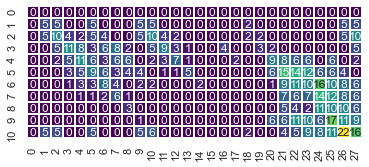

In [8]:
sns.heatmap(M,linecolor='white',linewidth=1,cmap="viridis",square=True,annot=True,cbar=False);

Let's visualize the `tracer` sub-matrices:

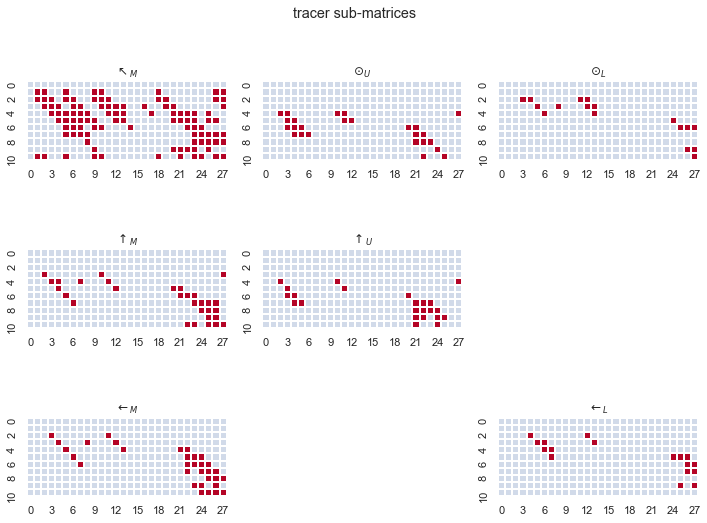

In [9]:
fig, ax = plt.subplots(3,3,figsize = (10,8))

for i,m in enumerate([[0,0,r"$\nwarrow_{M}$"],[0,1,r"$\odot_{U}$"],[0,2,r"$\odot_{L}$"],
                      [1,0,r"$\uparrow_{M}$"],[1,1,r"$\uparrow_{U}$"],
                      [2,0,r"$\leftarrow_{M}$"],[2,2,r"$\leftarrow_{L}$"]]):
    sns.heatmap(tracer[:,:,i],cmap="coolwarm",vmin=-0.5,vmax=0.6,linecolor='white',
                linewidth=1,square=True,cbar=False,ax=ax[m[0]][m[1]])
    ax[m[0]][m[1]].set_title(m[2])

fig.delaxes(ax[1][2]); fig.delaxes(ax[2][1])
fig.suptitle("tracer sub-matrices")
fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

## 3. Traceback
The traceback function now permits movement between matrices.

In [10]:
alignment = seq.traceback_iterator(tracer,seq_1,seq_2,mat=M,local=True,affine=True)
for i,e in enumerate(alignment):
    print(str(i+1)+".","\n",e[0],"\n",e[1],"\n")

1. 
 ----------------KKSGGLLLGK- 
 KKASKASPKKPHPHHSPRNGGGGLGKK 



## 4. Example Alignments

Aligning more sequences.

### 1.

In [11]:
seq_2 = "KKASKASPKKPHPHHSPRNGGGGLGKK"
seq_1 = "KKSGGLLLGK"

S = pd.read_csv('blosum62.csv',index_col=0)
g=-6
g_open = -6; g_ext = -6

In [12]:
_,_,_,_,_ = seq.affine_local_dp(seq_1,seq_2,S,g_open,g_ext,disp_alignments = True)

Max. score = 22.0
1. 
 ----------------KKSGGLLLGK- 
 KKASKASPKKPHPHHSPRNGGGGLGKK 



For equal opening and extension penalties, the affine case reduces to the linear case:

In [13]:
_,_,_ = seq.local_dp(seq_1,seq_2,S,g,disp_alignments = True,N=15)

Max. score = 22.0
1. 
 ----------------KKSGGLLLGK- 
 KKASKASPKKPHPHHSPRNGGGGLGKK 



### 2.

In [14]:
seq_1 = "ATCCCCGGGGGGGCT"
seq_2 = "AT"

S = pd.read_csv('dna_transition_transversion.csv',index_col=0)
g_open = -5; g_ext = -2

In [15]:
_,_,_,_,_ = seq.affine_local_dp(seq_1,seq_2,S,g_open,g_ext,disp_alignments = True)

Max. score = 4.0
1. 
 ATCCCCGGGGGGGCT 
 AT------------- 



### 3.

In [16]:
seq_1 = "KRRLHMNGDPRS"
seq_2 = "PQRS"

S = pd.read_csv('PAM250.csv',index_col=0)
g_open = -2; g_ext = -1

In [17]:
_,_,_,_,_ = seq.affine_local_dp(seq_1,seq_2,S,g_open,g_ext,disp_alignments = True)

Max. score = 12.0
1. 
 KRRLHMNGDP-RS 
 ---------PQRS 

